### 1. **Setup and import the libraries**
Import the necessary libraries for data manipulation, model building, evaluation, and saving/loading the model.

In [19]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os

# For model building and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler

# For saving the model
import joblib

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

### 2. **Load the Dataset**

In [20]:
# Define the path to the dataset
data_path = '../data/data.csv'

# Load the dataset
df = pd.read_csv(data_path)

# Display the first few rows
df.head()

,Unnamed: 0,location,country,gender,age,vis_wuhan,from_wuhan,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,result
0,0,104,8,1,66.0,1,0,14,31,19,12,3,1,8,1
1,1,101,8,0,56.0,0,1,14,31,19,12,3,1,0,0
2,2,137,8,1,46.0,0,1,14,31,19,12,3,1,13,0
3,3,116,8,0,60.0,1,0,14,31,19,12,3,1,0,0
4,4,116,8,1,58.0,0,0,14,31,19,12,3,1,0,0


### 3. **Data preprocessing**
Even though the data is preprocessed, it's essential to ensure that all features are correctly formatted and handle any potential issues.

In [21]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Drop columns that are not needed or are identifiers
# Assuming 'location' and 'country' are categorical and may be encoded later
# For simplicity, let's drop 'location' and 'country' if not needed
df = df.drop(['location', 'country'], axis=1)
df.drop(columns=["Unnamed: 0"],inplace=True)

# Separate features and target
X = df.drop('result', axis=1)
y = df['result']

# Display feature names
print("Feature columns:")
print(X.columns)

Missing values per column:
Unnamed: 0      0
location        0
country         0
gender          0
age             0
vis_wuhan       0
from_wuhan      0
symptom1        0
symptom2        0
symptom3        0
symptom4        0
symptom5        0
symptom6        0
diff_sym_hos    0
result          0
dtype: int64
Feature columns:
Index(['gender', 'age', 'vis_wuhan', 'from_wuhan', 'symptom1', 'symptom2',
       'symptom3', 'symptom4', 'symptom5', 'symptom6', 'diff_sym_hos'],
      dtype='object')


### 4. **Encode Categorical Variables**
Naïve Bayes requires numerical input. Encode categorical variables such as `gender`, `vis_wuhan`, and `from_wuhan`.

In [22]:
# Identify categorical columns
categorical_cols = ['gender', 'vis_wuhan', 'from_wuhan']

# One-Hot Encode categorical variables
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Display the transformed features
X.head()

,age,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,gender_1,gender_2,vis_wuhan_1,from_wuhan_1
0,66.0,14,31,19,12,3,1,8,1,0,1,0
1,56.0,14,31,19,12,3,1,0,0,0,0,1
2,46.0,14,31,19,12,3,1,13,1,0,0,1
3,60.0,14,31,19,12,3,1,0,0,0,1,0
4,58.0,14,31,19,12,3,1,0,1,0,0,0


### 5. **Feature Scaling**
Scaling features can improve the performance of some Naïve Bayes variants, especially **GaussianNB**.

In [23]:
# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the features
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for convenience
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Display the scaled features
X_scaled.head()

,age,symptom1,symptom2,symptom3,symptom4,symptom5,symptom6,diff_sym_hos,gender_1,gender_2,vis_wuhan_1,from_wuhan_1
0,1.101492,0.465755,0.401355,0.244914,0.135161,0.054668,0.03406,2.971339,1.103861,-0.498913,2.120570,-0.347533
1,0.437943,0.465755,0.401355,0.244914,0.135161,0.054668,0.03406,-0.422230,-0.905911,-0.498913,-0.471571,2.877424
2,-0.225607,0.465755,0.401355,0.244914,0.135161,0.054668,0.03406,5.092319,1.103861,-0.498913,-0.471571,2.877424
3,0.703363,0.465755,0.401355,0.244914,0.135161,0.054668,0.03406,-0.422230,-0.905911,-0.498913,2.120570,-0.347533
4,0.570653,0.465755,0.401355,0.244914,0.135161,0.054668,0.03406,-0.422230,1.103861,-0.498913,-0.471571,-0.347533


 ### 6. **Split the Dataset**
Divide the data into training, validation, and testing sets: 70% training, 15% validation, and 15% testing.

In [24]:
# First, split into training and temp (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.30, random_state=42, stratify=y)

# Then, split temp into validation and test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 604
Validation set size: 129
Test set size: 130


### 7. **Train the Naïve Bayes Classifier**
We'll use Gaussian Naïve Bayes as it's suitable for continuous data.

In [25]:
# Initialize the Gaussian Naïve Bayes classifier
gnb = GaussianNB()

# Train the model on the training data
gnb.fit(X_train, y_train)

GaussianNB()

### 8. **Evaluate the model**
Evaluate the trained model on the validation set using various metrics.

In [26]:
# Predict on the validation set
y_val_pred = gnb.predict(X_val)
y_val_proba = gnb.predict_proba(X_val)[:,1]

# Calculate evaluation metrics
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_proba)

print("Validation Set Evaluation:")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))

Validation Set Evaluation:
Precision: 0.1391
Recall:    1.0000
F1-Score:  0.2443
ROC AUC:   0.9013

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.12      0.22       113
           1       0.14      1.00      0.24        16

    accuracy                           0.23       129
   macro avg       0.57      0.56      0.23       129
weighted avg       0.89      0.23      0.22       129



### 10. **ROC Curve Visualization**
Visualize the ROC curve to assess the model's performance.

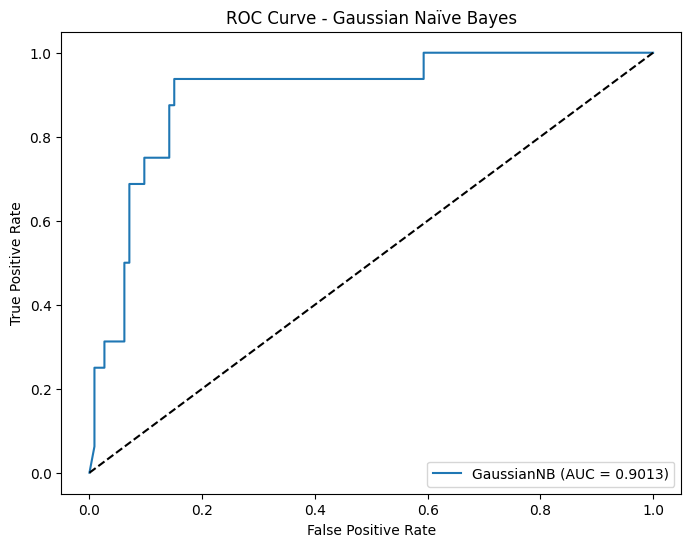

In [27]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'GaussianNB (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gaussian Naïve Bayes')
plt.legend(loc='lower right')
plt.show()

### **11. Test Set Evaluation**
After validating the model, evaluate its performance on the test set.

In [28]:
# Predict on the test set
y_test_pred = gnb.predict(X_test)
y_test_proba = gnb.predict_proba(X_test)[:,1]

# Calculate evaluation metrics
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)
roc_auc_test = roc_auc_score(y_test, y_test_proba)

print("Test Set Evaluation:")
print(f"Precision: {precision_test:.4f}")
print(f"Recall:    {recall_test:.4f}")
print(f"F1-Score:  {f1_test:.4f}")
print(f"ROC AUC:   {roc_auc_test:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

Test Set Evaluation:
Precision: 0.1368
Recall:    1.0000
F1-Score:  0.2406
ROC AUC:   0.8728

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.11      0.20       114
           1       0.14      1.00      0.24        16

    accuracy                           0.22       130
   macro avg       0.57      0.56      0.22       130
weighted avg       0.89      0.22      0.21       130



### **12. Export the Trained Model**
Save the trained model and scaler for future use in the main notebook.

In [29]:
# Define the directory to save the model
model_dir = 'models/naive_bayes/'

# Create the directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Save the trained model
model_path = os.path.join(model_dir, 'naive_bayes_model.joblib')
joblib.dump(gnb, model_path)
print(f"Model saved to {model_path}")

# Also, save the scaler to ensure consistent preprocessing
scaler_path = os.path.join(model_dir, 'scaler.joblib')
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

Model saved to models/naive_bayes/naive_bayes_model.joblib
Scaler saved to models/naive_bayes/scaler.joblib
